<a href="https://colab.research.google.com/github/Colley-K/capstone_projects/blob/master/8a_nu_data_cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#8a.nu Data Cleaning for Recommendation System

##Other Variations to this Notebook
* This notebook is the full cleaning report, but there are two other reports that are a lot less aggressive in their cleaning, and will be used to test different results with the recommendation algorithm
* Click [here](https://colab.research.google.com/drive/19sAidEVHV7NeCkX10v1qDKPV8SXDqd5M#scrollTo=PunkdjGpS3ev) for notebook that filters out names only listed once 
  >* In contrast, this notebook filters out names that occur less than ten times
* Click [here](https://colab.research.google.com/drive/1jm-Q7eKbdrzaoul6sXbv7ZnnJLWEUS77) for notebook that includes unrated climbs to test an implicit rating system

##Importing data from Kaggle
Using the Kaggle API, this dataset was downloaded as an SQLite database, transformed into a Pandas dataframe, and then exported as a CSV

>Click [here](https://colab.research.google.com/drive/1S4io5Nvz0lcnri_Lz9Mpa_TwLNeoSzGb#scrollTo=0BhPF3cSDvYk) to view the import notebook

>Click [here](https://www.kaggle.com/dcohen21/8anu-climbing-logbook) to view the data set on Kaggle 

##The Initial Set Up:

In [0]:
#Colab stuffs:

#get a fast operator system
!nvidia-smi

#mount google drive
from google.colab import drive
drive.mount('/content/drive')#click on the link it provides and copy and paste that code into the authorization area
!ls "/content/drive/My Drive" #shows whats in your drive once its mounted

#access the OS system to work with current directories:
import os 
os.getcwd() 

Tue May 21 20:01:19 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   29C    P8    25W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

'/content'

In [0]:
#Installs
!pip install jellyfish
!pip install fuzzy
!pip install phonetics
!pip install country_converter --upgrade

#imports
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import jellyfish
import phonetics
import fuzzy
import hashlib
import base64
import country_converter as coco


#reconfigure default settings
sns.set_palette(sns.color_palette("hls", 8))
matplotlib.rc('figure', figsize = (20, 8))
matplotlib.rc('font', size = 14)
matplotlib.rc('axes.spines', top = False, right = False)
matplotlib.rc('axes', grid = False)
matplotlib.rc('axes', facecolor = 'white')

Requirement already up-to-date: country_converter in /usr/local/lib/python3.6/dist-packages (0.6.6)


##Import CSV Files

In [0]:
#Turn the CSV files into data frames

ascent = pd.read_csv('drive/My Drive/Capstone/data/ascent.csv', low_memory=False) 

grade = pd.read_csv('drive/My Drive/Capstone/data/grade.csv', low_memory=False) #for filtering later



In [0]:
ascent.info()
grade.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4111878 entries, 0 to 4111877
Data columns (total 28 columns):
id                      object
user_id                 int64
grade_id                float64
notes                   object
raw_notes               int64
method_id               int64
climb_type              int64
total_score             int64
date                    int64
year                    float64
last_year               float64
rec_date                float64
project_ascent_date     float64
name                    object
crag_id                 float64
crag                    object
sector_id               float64
sector                  object
country                 object
comment                 object
rating                  float64
description             object
yellow_id               float64
climb_try               float64
repeat                  float64
exclude_from_ranking    float64
user_recommended        float64
chipped                 float64
dtypes: flo

#Brief Feature Analysis

####Used the following methods to analyze the columns:

* .head(), .info(), .dtypes, .shape(), .groupby, .count(), [.isnull().sum()], [.value_counts(dropna= False).head(50)]

####For the Recommendation System:

* Only need three columns and one table (out of four) for the surprise collaborative filtering recommendation system:
>* ascent.ratings
>* ascent.name
>* ascent.user_id
* Ratings 

>* Droping 48% of my data frame (from 4 million entries to 2 million) based on this column  because only half of the entries have a rating tied to them, and it is crucial for my recommendation system to have this information. Also, with 2 million entries, I still have a large enough sample size to work with.
>* Also, will drop the 7 four star ratings because it is not possible to rate a climb higher than three stars 

* User_id

>* User_id values match up with the user table, and on brief analysis there doesn't seem to be any incorrect values

* Names 

>* User entered string information
>* Lots of clean up needed for this column
>* Will need to normalize data first and then try different fuzzy techniques
>* Need to encode this column for the surprise libraries recommendation system

####Filtering the recommendation output:

* I will create a filtering system for the recommendation to provide more accurate output
* Will need to utilize the Grade table and the Ascent table:
>* ascent.country
>* ascent.grade_id
>* ascent.climb_type
>* grade.id
>* grade.usa_routes
>* grade.usa_boulders

* ascent.country

>* make capitalize all letters
>* use coco.converter to filter out any incorrect/invalid three digit country codes
>* impute the rest of the null values by calculating the mode of the countries grouped per the name of the climb (groupby)

* ascent.grade_id & grade.id 

>* Correspond to their correct alloted values, no clean up needed

* ascent.climb_type

>* 0 = rope climbing
1 = bouldering
>* approx. double the amount of rope climbs logged versus bouldering climbs

* grade.usa_routes & grade.usa_boulders

>* Will not be using the European rock climbing rating system 
>* Use the forward fill to match up the European ratings to the USA ratings

#Dropping Columns

In [0]:
#Dropping Columns
cols = ["user_id", "name","rating", "country", "climb_type", "grade_id"]
filter_cols = ["id", "usa_routes", "usa_boulders"]

ascent = ascent[cols]
grade = grade[filter_cols]


#Dropping the Unrated Routes

In [0]:
#Halving the data frame based on the "rating" column
ascent = ascent[ascent.rating > 0] #taking out any climb logs that were never given a star rating

#Removing the four star entries because you can only rate a climb 1-3 stars
ascent = ascent[ascent.rating < 4] #taking out any climb logs that were never given a star rating

ascent.rating.value_counts()#checking if it worked


3.0    954584
2.0    802708
1.0    360852
Name: rating, dtype: int64

#Removing Null Values & Converting Data Types

*I will only be removing null values in features with 5  or less null values. The "name" column (with more than 5 nulls) will be handled differently*

**Why delete nulls now?** the ratings and grade_id columns are float64 data types, but they should be int64 (example: 1.0, 2.0, 3.0). The only reason they are floats is because they have null values in their columns. 

**Action:**
* delete nulls
* convert to int64



In [0]:
#getting rid of the NaN values in the columns with less than 5 nulls
ascent= ascent.dropna(axis=0, subset=['grade_id', 'rating']) 

In [0]:
#changing data types:

cols2 = ['grade_id', 'rating'] #create a list of all the columns you want to convert to a int64
ascent[cols2] = ascent[cols2].astype('int64') #adjust the columns to int64

#double data types
ascent.dtypes

user_id        int64
name          object
rating         int64
country       object
climb_type     int64
grade_id       int64
dtype: object

#Detailed Feature Analysis

##*Ascent Table*

###Ratings
* 1-3 stars of how much the route was enjoyed
* 0 means not rated. Does NOT MEAN given 0 stars
>* 1993725 or 48% are 0's
>* two NaN values
* This is a vital component to our recommendation system, thus we dropped all "0" entries & NaN values so every climb has a rating corresponding to it now.
>* this decreased our data frame by 48%, but we still have aorund 2 million entries to work with which is plenty with the recommendation system

In [0]:
#seeing the distribution of ratings
ascent.rating.describe()

count    2.118144e+06
mean     2.280308e+00
std      7.365190e-01
min      1.000000e+00
25%      2.000000e+00
50%      2.000000e+00
75%      3.000000e+00
max      3.000000e+00
Name: rating, dtype: float64

##Name Column

* This column represents the name of the rock climb entered manually by the individual user
* This is a very important feature of the data set, as it will be the output of my recommendation system
>

###Normalizing:

* Make the column all lower case
* Exchange the "&" sign for "and"
* **Remove**: 
>* spaces before, after, or inbetween the names
>* special characters (, . - ! ')
>>* I will not include "?" because this represents invalid names
>* take away all accent marks in foreign language names
* **Filter out**: 
>* all these columns using a regex expression that only accepts letters & numbers, and turn anything that doesn't match this expression into NaN values. 
>>* after researching, I will leave numerics because there are some climbs that have all numerics as their name
>* phrases such as "I dont know" and turn them into NaN values
>* names that are less than three characters long to catch any fake names like "x", "8", or "na"     




In [0]:
#Normalizing Name Column

ascent[["name"]] = ascent[["name"]].apply(lambda x: x.str.lower().str.replace(" ", ""))#change all to lower case and striping away blank spaces before, after, or inbetween names
ascent[["name"]] = ascent[["name"]].apply(lambda x: x.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8'))#taking away accent marks from foreign names
ascent = ascent.replace(to_replace = "[!\-'.,]", value = '', regex = True) #replacing all special characters with blanks
ascent = ascent.replace(to_replace = "[&]", value = "and", regex = True) #replacing all & characters with "and"


###NaN values:
>* account for roughly 9% of the total data frame
>* there would not be any way to accurately guess or imputate a name for these values 
>* this will be the output of my recommendation system, thus, is a critical component of my project, and would not be wise to incorrectly guess how to fill in these values
>* since it accounts for less than 10%, I will be dropping all the NaN values
>



In [0]:
#converting non-uniform strings into NaNs

#convert the strings that dont fit the regex expression [only letters] to NaN values
ascent = ascent.replace("[^a-zA-Z0-9]", value = np.nan, regex = True) #converting anything but letters & numbers to null values

#add values such as "unknown" to the NaN group
ascent= ascent.replace(['','noname','nn','dontknow', 'idontknow', 'dontknowname', 'dunno', 'idunno', 'unknown', 'unnamed', 'noname', 'senzanome'],np.NaN, regex = True)

#SIDE NOTE: this is how you would apply regex to a column:
#ascent[column].replace(r'[^a-zA-Z0-9\s]', np.nan, regex=True, inplace= True)

In [0]:
#droping the NaN's from the name column:
ascent= ascent.dropna(axis=0, subset=['name'])

#double check
assert ascent.name.notnull().all()

###Filter out names with less than 3 characters:

In [0]:
#filter out any names that are less than 3 characters:
ascent = ascent[ascent['name'].str.len() > 3]

In [0]:
#check to see the size of the DF
ascent.shape

(1962084, 6)

###Spelling Problem:
 >* There are multiple names that are spelled slightly different (example: "red rocks", "red rock canyon", "redrock canyons", "red rocks cayons"), and this will create noise in my dataset. 
>* **Potential Solutions**

   >> 1. **Phonetic Encoding**
   
   >>>* First try the jellyfish soundex algorithm to convert a string to a normalized phonetic encoding
   >>>* Next, try Double Metaphone which the author claims that in general it improves accuracy for all words to approximately 89% 
   
   >>>* This strategy would correct misspellings and encode my name column all in one line of code!
   >>>* **Potential problem** - if it too aggresively groups names together
   >>>* spell corrector would not work here because there are foreign language values
   
   >>2. **Filter Out Low Frequency Names**
   
 >>>* Although, not the most accurate answer, if a user misspells a name and enters that route on the website, the chances of another user entering and misspelling that name in the same way become less probable the greater the number of occurances. 
 >>>* First, I will look at name groupings and see what happens to the number of name groups when filtering out x amount of name occurances.  
   >>>* Next, I will filter out any names that don't occur x amount of times (to help filter out misspellings)
   
   >>3. **Fuzzy Wuzzy Techniques**
   
 >>>* If my recommendation system results are inaccurate, I will go back and look into using some fuzzy wuzzy probability ratio techniques
 >>>* However, with time contraints, I will see if the filtering technique listed above will suffice



###1.Phonetic Techniques: Soundex

* RESULT: Too aggresive grouping
* Drops the number of groups from around 400,000 to 5,793

In [0]:
ascent["soundex"] = ascent.name.apply(lambda x: jellyfish.soundex(x))
ascent.groupby("soundex").agg({"name": lambda x: ", ".join(x)})#see how soundex is grouping the values together

,name
soundex,
0000,"0031, 0031, 0031, 0031, 0031, 0031, 0031, 0031..."
0110,06pave
0112,"05101988vivachile, 05101988vivachile"
0116,"00faber, 00faber, 00faber, 00faber, 00faber, 0..."
0121,04vasyfreddy
0125,013vcenturii
0165,"08variantedelatigresse, 0fahrenheit"
0200,"01cg2, 01cs2, 01cs3, 01cs2, 01cs3, 0cyo"
0224,07yougoslab


In [0]:
#close up of one soundex group Z610 where you can see all the incorrect names it groups
ascent[ascent.soundex == 'Z610'] 

,user_id,name,rating,country,climb_type,grade_id,soundex
7948,654,zooropa,3,NaN,0,59,Z610
102128,3933,zarbi,2,FRA,0,53,Z610
199357,654,zooropae,3,NaN,0,62,Z610
311199,10640,zarbi,1,FRA,0,53,Z610
408947,13431,zeropo,2,FRA,1,51,Z610
482326,4666,zorba,2,CHE,1,42,Z610
502583,15897,zeropo,2,FRA,1,51,Z610
538382,10,zarbi,1,FRA,0,51,Z610
707480,15232,zorev,2,GBR,1,57,Z610
716424,2508,zarbi,3,FRA,0,53,Z610


###1. Phonetic Techniques: Double Metaphone: *an improved & updated phonetic encoding algorithm*
* RESULT: did much better than soundex, but is it too agressive still?
* Drops the number of groups from around 400,000 to 12,736
* Might be too agressive still, and could instead filter out any name that occurs less than 10 times.

In [0]:
#instantiating double metaphone
dmetaphone = fuzzy.DMetaphone(4)

#dmetaphone = fuzzy.DMetaphone(4) #create an instance of dmetaphone
ascent["metaphone"] = ascent.name.apply(lambda x: dmetaphone(x))# apply double metaphone to my names columns and create a column of output

#extract the first & strongest match of double metaphone and use as my encoded column
ascent.loc[:, 'name_encode'] = ascent.metaphone.map(lambda x: x[0])
ascent.groupby("name_encode").agg({"name": lambda x: ", ".join(x)})


,name
name_encode,
b'0',"the512, thaw, the512, the159, the300, theway, ..."
b'00',"thaithai, the9th, theeighth, theeighth, theeig..."
b'00F',"thethief, thethief, thethief, thethief, thethi..."
b'00FL',"the13thfloor, the13thfloor, the13thfloor, the1..."
b'00K',"thawthecrew, thethug, thethug"
b'00KK',"thewaythecookiecrumbles, thewaythecookiecrumbl..."
b'00KN',"the7thcontinent, the7thcontinent, the7thcontinent"
b'00LM',the5thelement
b'00M',"thethumb, thethumb, thethumb, thethumb, thethu..."


In [0]:
#investigating individual columns
ascent[ascent.name_encode == b'XXNT']

,user_id,name,rating,country,climb_type,grade_id,soundex,metaphone,name_encode
82436,2465,chouchounet,1,CAN,1,55,C253,"[b'XXNT', b'XKNT']",b'XXNT'
127490,3876,chouchounette,1,CAN,1,51,C253,"[b'XXNT', b'XKNT']",b'XXNT'
247900,1735,chaouchuinade,2,FRA,0,49,C253,"[b'XXNT', b'XKNT']",b'XXNT'
369815,10238,tchatchounette,3,FRA,0,46,T232,"[b'XXNT', None]",b'XXNT'
517596,16242,tchatchounette,3,FRA,0,49,T232,"[b'XXNT', None]",b'XXNT'
644995,6123,tchatchounette,3,FRA,0,46,T232,"[b'XXNT', None]",b'XXNT'
698167,10065,tchatchounette,1,FRA,0,46,T232,"[b'XXNT', None]",b'XXNT'
838597,18282,chouchounette,1,CAN,1,53,C253,"[b'XXNT', b'XKNT']",b'XXNT'
838998,17730,chouchounette,3,CAN,1,51,C253,"[b'XXNT', b'XKNT']",b'XXNT'
885852,5135,cheechandchong,2,DEU,1,49,C253,"[b'XXNT', b'XKNT']",b'XXNT'


###2. Filtering Out Lower Frequency Names
>* The results of both the soundex and doublemetaphone were both too aggresive and not accurate enough
> * After analyzing what filtering out the names with lower counts will do to my data set, I settled upon filtering out any names that occur less than ten times
>* Still leaves more than 1.2 million entries and just under 40,000 name groupings

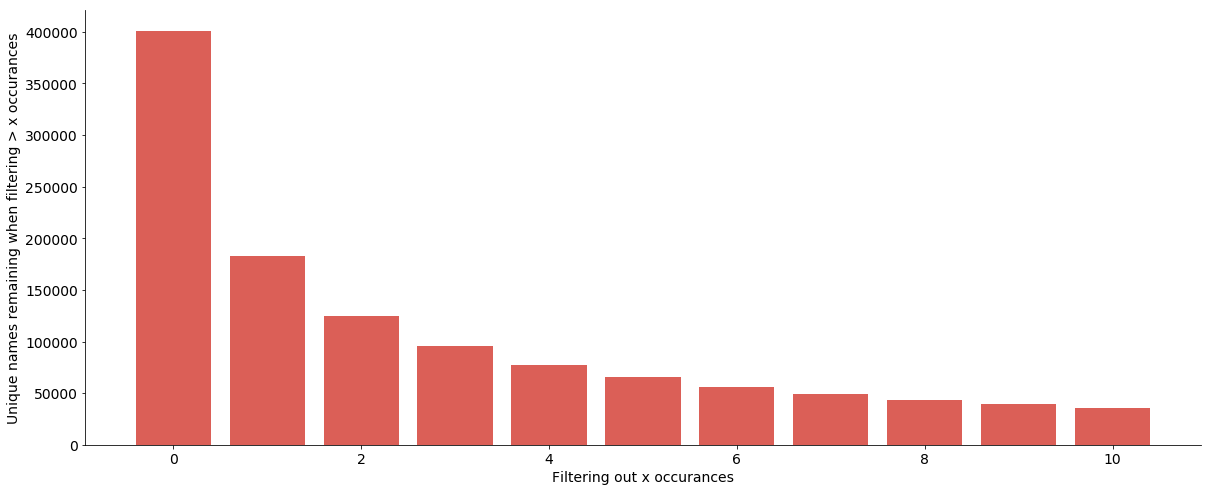

In [0]:
#graphing what happens to the number of unique values when filtering out x number of occurances
plot_counts= {0:401030, 1:182957, 2:124409, 3:95373, 4:77549, 5:65313, 6:56234, 7:49296, 8:43721, 9:39268, 10:35597}
plt.bar(*zip(*plot_counts.items()))
plt.xlabel("Filtering out x occurances")
plt.ylabel("Unique names remaining when filtering > x occurances")
plt.show()

In [0]:
#filtering out names that occur < 10 times to filter out spelling errors

ascent= ascent.groupby('name').filter(lambda x: len(x) >= 10)

#count the number of name groups left in dataframe
ascent.name.nunique()

39466

In [0]:
#count number of entries left in the dataframe
ascent.shape

(1213567, 9)

In [0]:
#Will need to drop fuzzy testing rows here:

acent= ascent.drop(labels= ["soundex",	"metaphone", "name_encode"], axis=1)

   
###Encoding the Names Column:
 >* In order for the name column to work with the surprise collaborative algorthim, the name column must be encoded 
 >* Use base64 hashing to handle this large scale data set & numerous values

In [0]:
#Still decided between using Python's built in hash or hashlib base64. I need to look up if suprise library docs to see if it accept bytes. I don't like python's built in hash because its completely randomized, and can pose potential problems decoding later on.

#Base64 Hash: turns into bytes
ascent['name_id']= ascent["name"].astype(str).str.encode('UTF-8')\
          .apply(lambda x: base64.b64encode(hashlib.sha1(x).digest())) 

#basic built in hash: turns into a randomized integer: potential decoding problems
#ascent['name_id'] = ascent['name'].apply(hash)

#To decode Base64
# ascent['name_id']= ascent["name_id"]
#           .apply(lambda x: base64.b64decode(hashlib.sha1(x).digest()))
# base64.b64decode(coded_string)

##Climb Type:
* 0 = rope climbing
* 1 = bouldering
* approx. double the amount of rope climbs logged versus bouldering climbs
* *may want to think about segmenting these different climbs into different groups because typically boulderers are just wanting boulder routes and vice versa with rope climbs*

Text(0, 0.5, 'Count')

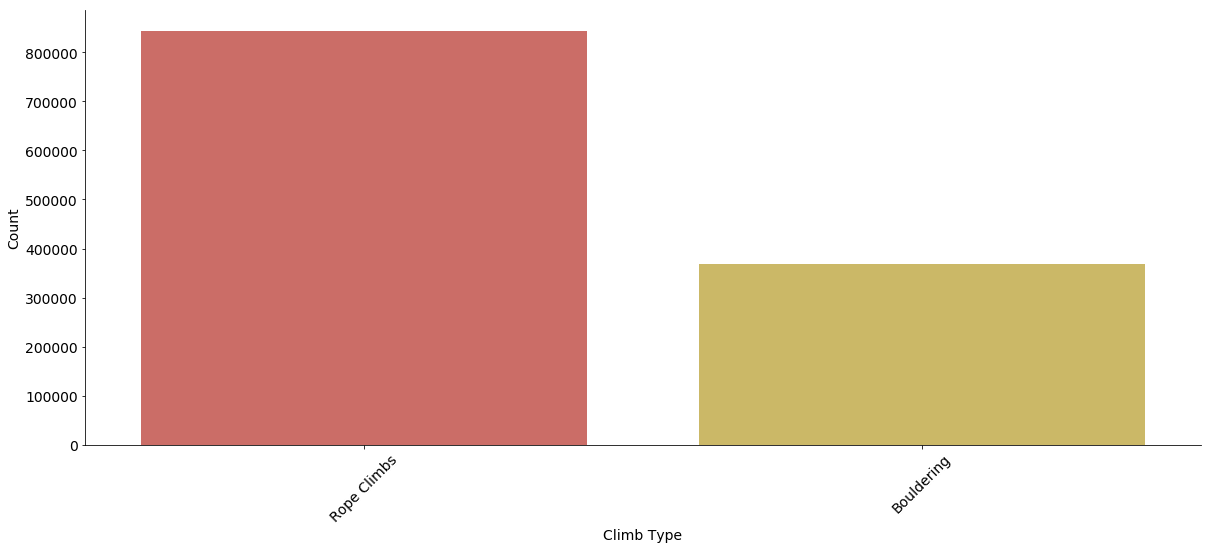

In [0]:

ascent.climb_type.value_counts()
#ascent.climb_type.value_counts().plot(kind='barh') #plotting the ropes verus bouldering climbs
climb_type_graph = sns.countplot(x='climb_type', data=ascent) #using seaborn to plot
climb_type_graph.set_xticklabels(['Rope Climbs', 'Bouldering'], rotation=45) #Set the tick labels for x
plt.xlabel("Climb Type")
plt.ylabel("Count")


##Grade ID:
* difficulty of climb 1-86 
* this rating system makes it possible to compare ratings across different countries rating systems
* 49 (USA 11d) is the most logged climbing grade
* Changed to int 64  from a float
* need to merge with grade table to get the full description of grades
* the 0's and low numbers are valid easy rated routes


Text(0, 0.5, 'Count')

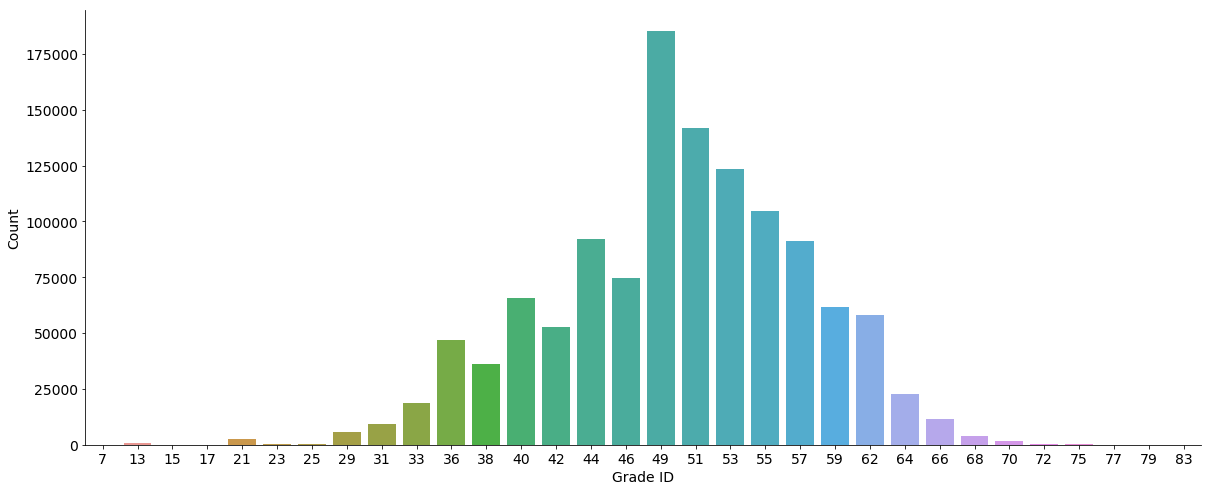

In [0]:
ascent.grade_id.value_counts()
#ascent.grade_id.value_counts().plot(kind='barh') #plotting 
ascent.grade_id.describe() #seeing summary statistics
sns.countplot(x='grade_id', data=ascent) #using seaborn to plot
plt.xlabel("Grade ID")
plt.ylabel("Count")


##Country 
* Country is entered via a drop down selection provided on website, however there are still a few incorrect entries

**Country Normalization** :
>1. Make column capital letters
>2. Use the country_converter to check if country values are valid, if not, I will turn them into null values
>3. Will use the mode aggregation per route name to populate null values of the country column


In [0]:
#make the country column capital letters
ascent['country'] = ascent.country.str.upper()

####Country Converter

* finds all values that are not valid three digit country codes, and converts them into NaN values
* VERY computationally expensive, thus I only ran once, and found that YUG & ROM where incorrectly entered
 >* I will drop these values from the DF
* Country coverter docs:
[githug](https://github.com/konstantinstadler/country_converter/blob/master/country_converter/country_converter.py)

In [0]:
#Using Country Converter to convert non valid three digit codes into NaNs
#this code is VERY computationally expensive. Thus, the code is commented out

#ascent['country']= ascent["country"].apply(lambda x: coco.convert(names= x, to='ISO3', not_found= np.NaN)) 

In [0]:
#ROM, YUG ARE NOT COUNTRIES, need to filter them out of the dataframe
ascent= ascent[(ascent.country != 'ROM') & (ascent.country != 'YUG')]
ascent.isnull().sum()

user_id            0
name               0
rating             0
country        14538
climb_type         0
grade_id           0
soundex            0
metaphone          0
name_encode      451
name_id            0
dtype: int64

####Imputing the Country's NaNs with the mode based on the name column
* Will groupby the route name column and then compute the mode of the country column to fill in the NaNs



In [0]:
#PROBLEM! this is mapping out NULL values now, because im grouping by the name? what is the work around?????????? need to map the mode excluding the NaN values could I write a lambda function with an if else statement??

# test["code_convert"] = test[test.notna()].apply(
#     lambda x: coco.convert(names=x, to="ISO3")
# )
# Maps out the mode values of the country based upon the route name
# mode_1 = ascent.groupby('name')['country'].apply(pd.Series.mode)
#check to see if theres a missing value
#fill it with the value of the dictionary

#ascent['country'] = ascent['name'].map(mode_1)

#ascent.fillna("country", mode_1)

#if this row is nan for country look up the name in mode_1 and replace the nan with that country 
#take mode_1 left join to ascent df and use that new column where the old column is missing
#take series object and turn it into a df
#left join to the ascent dt to name

#look to see if mode_1 is a sereis

#ascent['country'] = ascent['name'].map(mode_1)

#JSON project- question 3

####Delete the remaining NaN values


In [0]:
#deleting the reamining nulls from the country column & the random ones that came up in the name_id
ascent= ascent.dropna(axis=0, subset=['country'])

#double check
assert ascent.country.notnull().all()


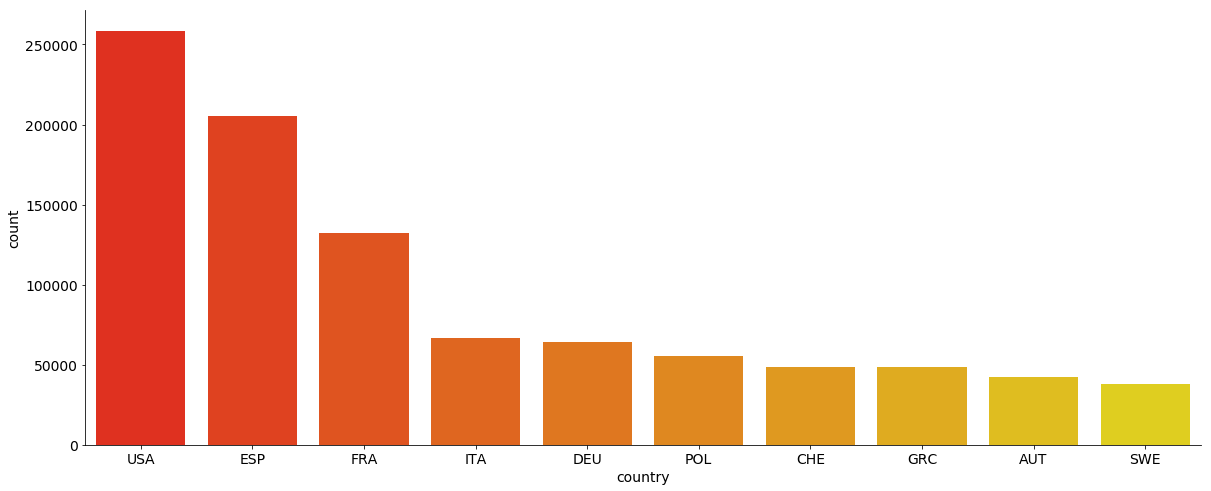

In [0]:
#graph the top ten countries climbs were logged in
sns.countplot(x="country", data=ascent, palette="autumn",
              order=ascent.country.value_counts().iloc[:10].index)

##*Grade Table*

####ID:
*  numbered 1-86 
* corresponds to the ascent table & it gives each climb a number 1-86 that corresponds to different rating systems in the US and France
* this column is correctly coded as an int64 data type, no work needs to be done on this column

In [0]:
grade.head()

,id,usa_routes,usa_boulders
0,1,3/4,VB
1,2,NaN,NaN
2,3,NaN,NaN
3,4,NaN,NaN
4,5,NaN,NaN


####Routes & Boulders:
* Need to forward fill all the USA columns so they correspond to the more numerous French Columns

In [0]:
#used forward fill on the USA values
grade[["usa_routes", "usa_boulders"]]= grade[["usa_routes", "usa_boulders"]].fillna(method='ffill')

In [0]:
#double check the table 
grade.head(10)

,id,usa_routes,usa_boulders
0,1,3/4,VB
1,2,3/4,VB
2,3,3/4,VB
3,4,3/4,VB
4,5,3/4,VB
5,6,3/4,VB
6,7,5.1,VB
7,8,5.1,VB
8,9,5.1,VB
9,10,5.1,VB


#Exporting Data Frames to CSV 

###Step 1: 

* copy the ascent table, and delete all rows except the three rows for the recommendation system (user_id, name_id, rating)


In [0]:
#create a new data frame that will serve as the reference to the recommendation table
ref_table = ascent.copy(deep=True)



###Step 2:
* merge the grade table with the reference table so all reference items are in one table

In [0]:
#left merge the reference table with grade table
ref_table = ref_table.merge(grade,how='left', left_on='grade_id', right_on='id')


###Step 3:
* drop unneccary columns in both data frames

In [0]:
ref_table= ref_table.drop(labels= ["id"], axis=1)
ascent = ascent[["user_id", "name_id", "rating"]]

###Final Shape of the Data Frames:



In [0]:
#number of entries in both tables:
ref_table.shape
ascent.shape

(1196988, 12)

In [0]:
#how many name groups
ascent.name_id.nunique()

39435

###Step 4:
* export files to google drive

In [0]:
from google.colab import files
ref_table.to_csv(r'/content/drive/My Drive/Capstone/data/ref_table.csv', index = None, header=True)
ascent.to_csv(r'/content/drive/My Drive/Capstone/data/ascent2.csv', index = None, header=True)